## 13. 신경망 실습

간단한 신경망 구조 적용의 일반적인 순서를 학습하기 위해 간단한 예제를 살펴보겠습니다.  

이전 시간에 회귀분석용 예제와 차원축소 예제에서 다루었던 Hitters 데이터셋과 California Housing 데이터셋을 이용하여 신경망을 학습하고 주요 변수를 예측하는 과정을 살펴보겠습니다.

### 13.1. Hitters 데이터셋

In [50]:
# 라이브러리 로딩
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 시드 설정
np.random.seed(42)

In [51]:
# 데이터셋 로딩 및 탐색
hitters = load_data('Hitters')
print("데이터 shape:", hitters.shape)
hitters.head()

데이터 shape: (322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


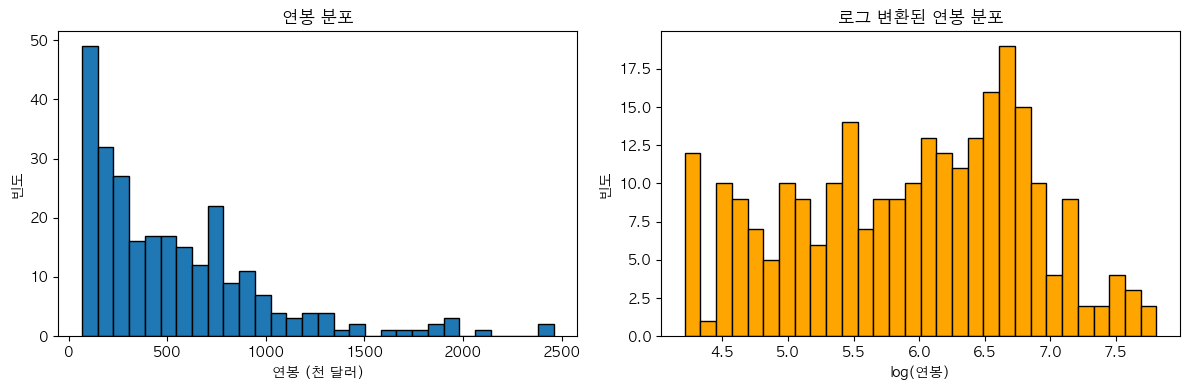

In [52]:
## 목표 변수(Salary) 분포 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(hitters['Salary'], bins=30, edgecolor='black')
plt.xlabel('연봉 (천 달러)')
plt.ylabel('빈도')
plt.title('연봉 분포')

plt.subplot(1, 2, 2)
plt.hist(np.log(hitters['Salary']), bins=30, edgecolor='black', color='orange')
plt.xlabel('log(연봉)')
plt.ylabel('빈도')
plt.title('로그 변환된 연봉 분포')

plt.tight_layout()
plt.show()

결측치를 제거하는 것이 데이터 전처리 과정에서 언제나 바람직한 것은 아니지만 다른 이론적인 기반이 없는 상황에서 결측치 제거는 상당히 준수한 효과를 가지는 결측치 처리방법입니다.  

이 코드에서는 신경망 적합이 목적이기 때문에 결측치를 모두 제거하겠습니다.

In [53]:
# 데이터 전처리 : 결측치 확인 및 제거
print("결측치 개수:")
print(hitters.isnull().sum())

hitters = hitters.dropna()
print(f"\n결측치 제거 후 데이터 shape: {hitters.shape}")

결측치 개수:
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

결측치 제거 후 데이터 shape: (263, 20)


신경망의 장점 중 하나는 데이터의 분포나 확률변수화 같은 복잡한 이론적인 검증이 필요없다는 점입니다. 물론 이론적인 뒷받침이 있는 모형의 경우 압도적으로 준수한 성능을 내줄 수 있습니다.  

예제에서는 분포의 쏠림 현상을 방지하기 위해 로그변환한 값을 반응변수로 사용하겠습니다. 

In [54]:
# 데이터 전처리 : 범주형 변수를 더미 변수로 변환
hitters_processed = pd.get_dummies(hitters, columns=['League', 'Division', 'NewLeague'], drop_first=True)

# 데이터 전처리 : Salary를 로그 변환
hitters_processed['LogSalary'] = np.log(hitters_processed['Salary'])
hitters_processed = hitters_processed.drop('Salary', axis=1)

In [55]:
# 데이터 전처리 : 예측변수 X, 반응변수 y 분리
X = hitters_processed.drop('LogSalary', axis=1)
y = hitters_processed['LogSalary']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 특성 이름 저장
feature_names = X.columns.tolist()
print(f"특성 개수: {len(feature_names)}")

X shape: (263, 19)
y shape: (263,)
특성 개수: 19


신경망 모형은 변수 간의 논리적인 관계를 예측하는 것이 목적이 아니기 때문에 전체 데이터를 이용하여 학습하는 경우 학습된 모형의 적합도를 이해하고 설명할 수 있는 수단이 없습니다. 그래서 필수적으로 학습용, 검증용, 시험용 데이터를 분리한 후 학습용 데이터로는 학습을, 검증용 데이터로는 학습 과정에서 적합도 평가를, 시험용 데이터로는 예측 성능을 평가하는 용도로 활용합니다.  

데이터의 수가 적은 경우에는 학습 : 검증 : 시험을 6:2:2 내지 8:1:1로 잡을 것을 권장하는데, 실제로 10만 단위가 넘어가는 대용량 데이터의 경우 학습:검증의 비율은 95:2.5:2.5, 98:1:1 수준으로까지 분할하기도 합니다. 

In [73]:
# 데이터 전처리 : 학습+검증 : 시험용 데이터 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"학습 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")

학습 데이터: (210, 19)
테스트 데이터: (53, 19)


변수들이 각기 다른 단위에서 입력되는 경우에는 활성화함수에 입력되는 합산값에 영향을 미칠 수 있기 때문에 신경망 모형에서는 일반적으로 변수들의 값을 표준화하는 것이 표준적인 절차입니다.  

눈여겨보실 부분은, 표준화를 적합(fit_transform)할 때에는 훈련용 데이터를 이용하고, 검증용 데이터는 변환(transform)만을 이용한다는 점입니다. 이를 통해, 검증용 데이터가 가지고 있는 특성이 신경망 적합, 검증 과정에 영향을 미치지 않도록 차단합니다.

In [74]:
# 데이터 전처리 : 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

은닉층을 1개 가지는 모형1과 2개 가지는 모형2를 이용하여 성능을 비교해보겠습니다.

In [92]:
# 모델1 : 은닉층 1개
model1 = MLPRegressor(
    hidden_layer_sizes=(20,),  # 64개 뉴런을 가진 은닉층 1개
    activation='relu',          # ReLU 활성화 함수
    solver='adam',              # Adam 옵티마이저를 사용합니다.
    learning_rate_init=0.001,   # 학습률은 초기 학습률을 의미하며 옵티마이저에서 역전파 과정에서 학습률을 조정합니다.
    max_iter=1000,              # 최대 반복 횟수
    random_state=42,
    early_stopping=True,        # 조기 종료 옵션 : 검증용 데이터와 훈련용 데이터의 손실함수값을 비교하여 개선이 없으면 학습을 종료합니다.
    validation_fraction=0.1,    # 검증 데이터 비율
    verbose=True
)

print("모델 1 학습 시작...")
model1.fit(X_train_scaled, y_train)
print("\n모델 1 학습 완료!")

모델 1 학습 시작...
Iteration 1, loss = 14.82090703
Validation score: -40.323360
Iteration 2, loss = 14.67727818
Validation score: -39.879897
Iteration 3, loss = 14.53428835
Validation score: -39.439652
Iteration 4, loss = 14.39215466
Validation score: -39.001045
Iteration 5, loss = 14.25055716
Validation score: -38.566154
Iteration 6, loss = 14.10942911
Validation score: -38.136343
Iteration 7, loss = 13.96869134
Validation score: -37.705373
Iteration 8, loss = 13.82894916
Validation score: -37.274590
Iteration 9, loss = 13.69016019
Validation score: -36.848310
Iteration 10, loss = 13.55237613
Validation score: -36.426012
Iteration 11, loss = 13.41573588
Validation score: -36.007586
Iteration 12, loss = 13.28003282
Validation score: -35.593073
Iteration 13, loss = 13.14513691
Validation score: -35.181682
Iteration 14, loss = 13.01107516
Validation score: -34.772914
Iteration 15, loss = 12.87806154
Validation score: -34.367911
Iteration 16, loss = 12.74606418
Validation score: -33.966809
Ite

/opt/homebrew/Caskroom/miniforge/base/envs/qlab/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [93]:
# 모델2 : 은닉층 2개
model2 = MLPRegressor(
    hidden_layer_sizes=(20, 40, 20),  # 입력층에서부터 은닉층이 가지는 노드의 수는 각각 128, 64개입니다.
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True
)

print("모델 2 학습 시작...")
model2.fit(X_train_scaled, y_train)
print("\n모델 2 학습 완료!")

모델 2 학습 시작...
Iteration 1, loss = 22.54843844
Validation score: -47.909210
Iteration 2, loss = 22.06023146
Validation score: -46.879875
Iteration 3, loss = 21.57748940
Validation score: -45.864983
Iteration 4, loss = 21.10092856
Validation score: -44.848141
Iteration 5, loss = 20.62726485
Validation score: -43.838033
Iteration 6, loss = 20.15560961
Validation score: -42.832607
Iteration 7, loss = 19.68597266
Validation score: -41.816038
Iteration 8, loss = 19.21629122
Validation score: -40.804508
Iteration 9, loss = 18.74895114
Validation score: -39.789714
Iteration 10, loss = 18.28219742
Validation score: -38.774497
Iteration 11, loss = 17.81642943
Validation score: -37.758277
Iteration 12, loss = 17.35348357
Validation score: -36.733500
Iteration 13, loss = 16.89310005
Validation score: -35.701537
Iteration 14, loss = 16.43479211
Validation score: -34.667913
Iteration 15, loss = 15.98051430
Validation score: -33.640332
Iteration 16, loss = 15.52885566
Validation score: -32.618313
Ite

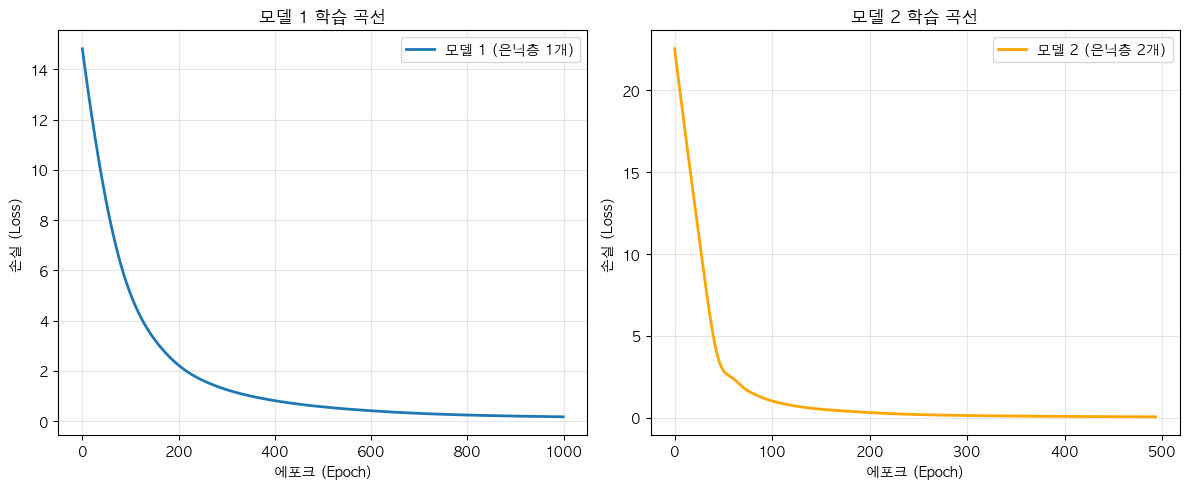

모델 1 최종 반복 횟수: 1000
모델 2 최종 반복 횟수: 494


In [94]:
# 학습 곡선 (손실 함수 변화)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model1.loss_curve_, label='모델 1 (은닉층 1개)', linewidth=2)
plt.xlabel('에포크 (Epoch)')
plt.ylabel('손실 (Loss)')
plt.title('모델 1 학습 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(model2.loss_curve_, label='모델 2 (은닉층 2개)', color='orange', linewidth=2)
plt.xlabel('에포크 (Epoch)')
plt.ylabel('손실 (Loss)')
plt.title('모델 2 학습 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"모델 1 최종 반복 횟수: {model1.n_iter_}")
print(f"모델 2 최종 반복 횟수: {model2.n_iter_}")

In [95]:
# 예측
y_train_pred1 = model1.predict(X_train_scaled)
y_test_pred1 = model1.predict(X_test_scaled)

y_train_pred2 = model2.predict(X_train_scaled)
y_test_pred2 = model2.predict(X_test_scaled)

# 평가 지표 계산
def evaluate_model(y_true, y_pred, dataset_name, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} - {dataset_name}")
    print("="*50)
    print(f"RMSE (평균 제곱근 오차): {rmse:.2f}")
    print(f"MAE (평균 절대 오차): {mae:.2f}")
    print(f"R² (결정계수): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# 모델 1 평가
model1_train_scores = evaluate_model(y_train, y_train_pred1, "학습 데이터", "모델 1")
model1_test_scores = evaluate_model(y_test, y_test_pred1, "테스트 데이터", "모델 1")

# 모델 2 평가
model2_train_scores = evaluate_model(y_train, y_train_pred2, "학습 데이터", "모델 2")
model2_test_scores = evaluate_model(y_test, y_test_pred2, "테스트 데이터", "모델 2")


모델 1 - 학습 데이터
RMSE (평균 제곱근 오차): 0.63
MAE (평균 절대 오차): 0.49
R² (결정계수): 0.5180

모델 1 - 테스트 데이터
RMSE (평균 제곱근 오차): 1.01
MAE (평균 절대 오차): 0.78
R² (결정계수): -0.5872

모델 2 - 학습 데이터
RMSE (평균 제곱근 오차): 0.41
MAE (평균 절대 오차): 0.30
R² (결정계수): 0.7913

모델 2 - 테스트 데이터
RMSE (평균 제곱근 오차): 0.80
MAE (평균 절대 오차): 0.60
R² (결정계수): 0.0143


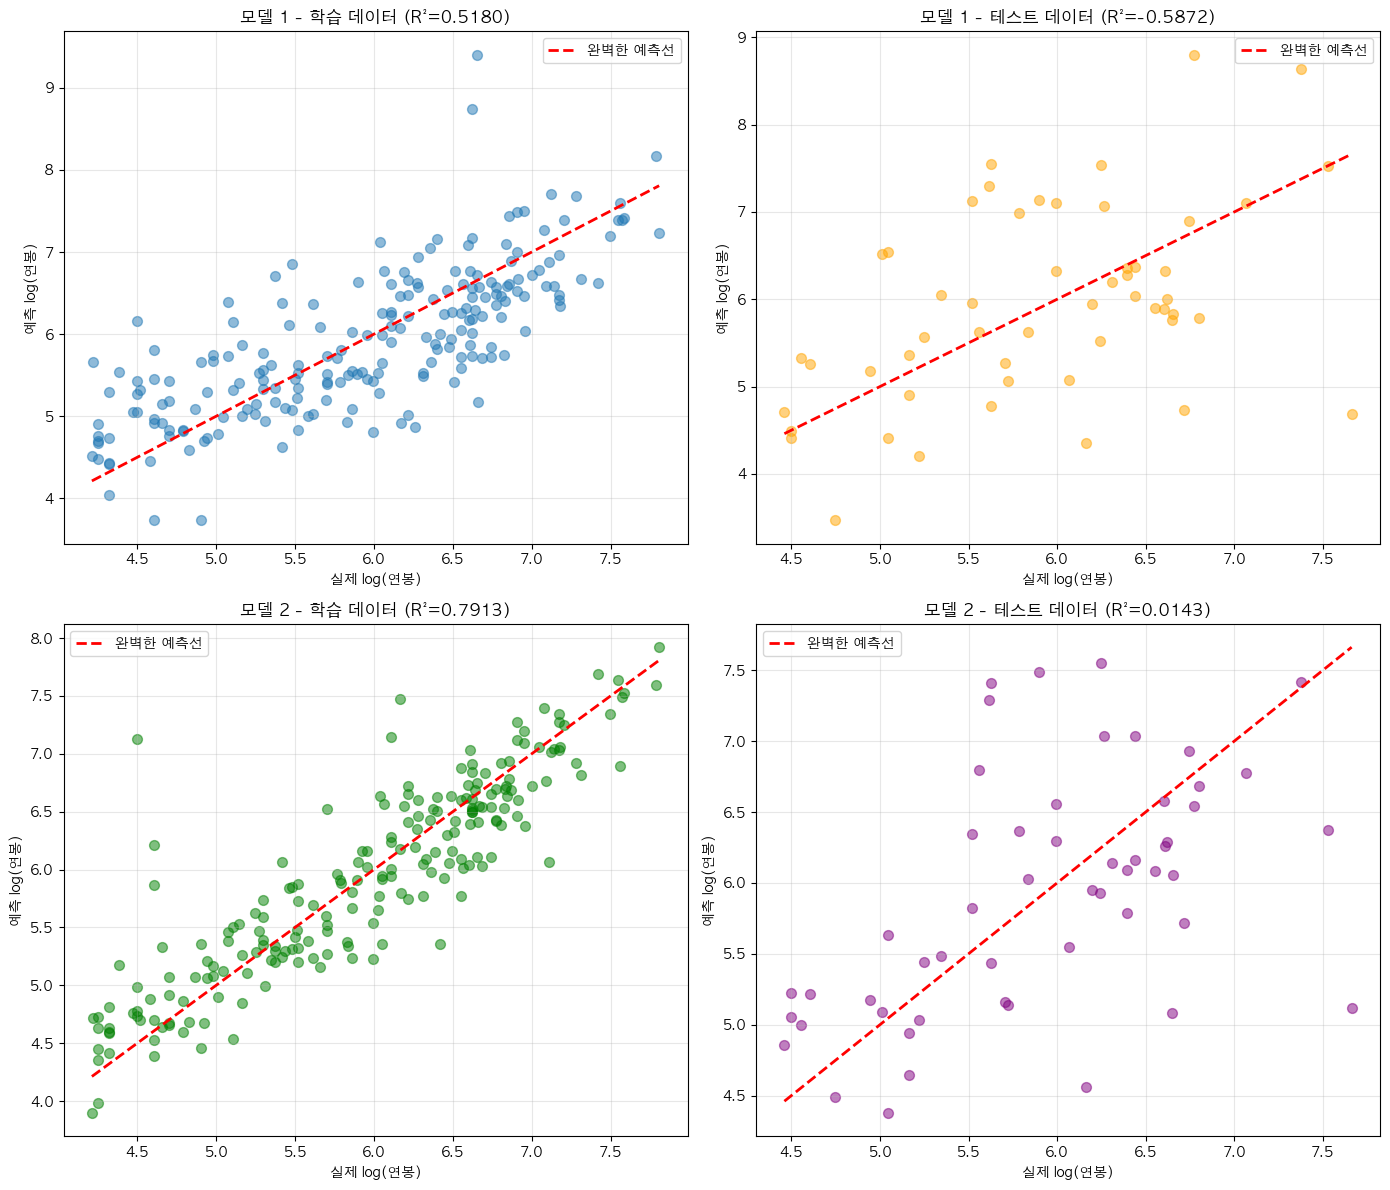

In [96]:
# 실제값 vs 예측값 산점도 (로그 스케일)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 모델 1 - 학습 데이터
axes[0, 0].scatter(y_train, y_train_pred1, alpha=0.5, s=50)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[0, 0].set_xlabel('실제 log(연봉)')
axes[0, 0].set_ylabel('예측 log(연봉)')
axes[0, 0].set_title(f'모델 1 - 학습 데이터 (R²={model1_train_scores["R2"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 모델 1 - 테스트 데이터
axes[0, 1].scatter(y_test, y_test_pred1, alpha=0.5, s=50, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[0, 1].set_xlabel('실제 log(연봉)')
axes[0, 1].set_ylabel('예측 log(연봉)')
axes[0, 1].set_title(f'모델 1 - 테스트 데이터 (R²={model1_test_scores["R2"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 모델 2 - 학습 데이터
axes[1, 0].scatter(y_train, y_train_pred2, alpha=0.5, s=50, color='green')
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[1, 0].set_xlabel('실제 log(연봉)')
axes[1, 0].set_ylabel('예측 log(연봉)')
axes[1, 0].set_title(f'모델 2 - 학습 데이터 (R²={model2_train_scores["R2"]:.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 모델 2 - 테스트 데이터
axes[1, 1].scatter(y_test, y_test_pred2, alpha=0.5, s=50, color='purple')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[1, 1].set_xlabel('실제 log(연봉)')
axes[1, 1].set_ylabel('예측 log(연봉)')
axes[1, 1].set_title(f'모델 2 - 테스트 데이터 (R²={model2_test_scores["R2"]:.4f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

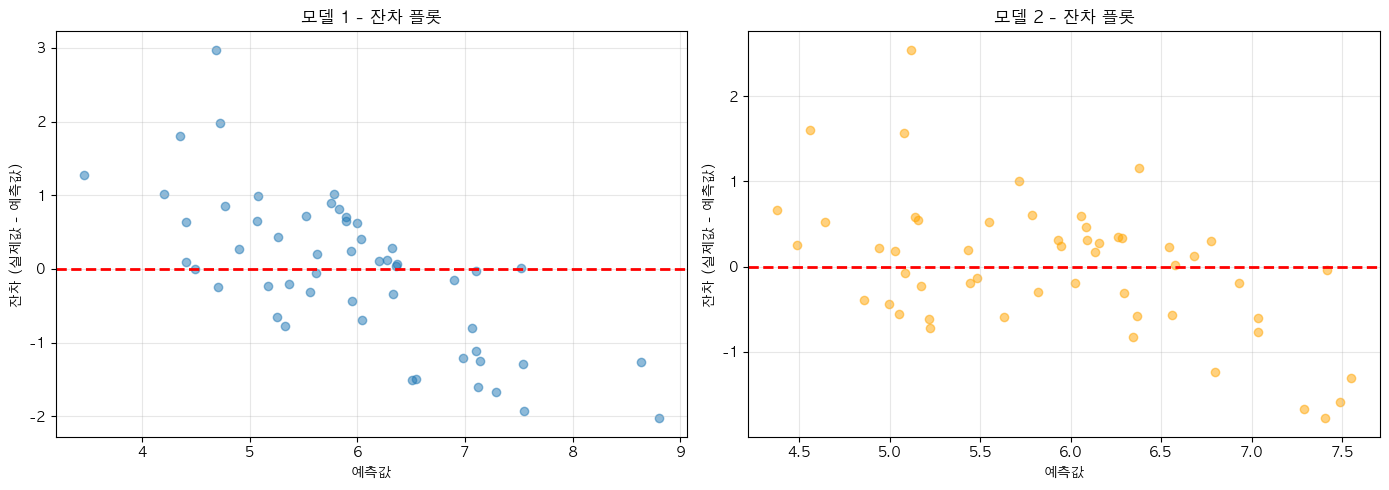

In [97]:
# 잔차(오차) 분석
residuals1 = y_test - y_test_pred1
residuals2 = y_test - y_test_pred2

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 모델 1 잔차
axes[0].scatter(y_test_pred1, residuals1, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('예측값')
axes[0].set_ylabel('잔차 (실제값 - 예측값)')
axes[0].set_title('모델 1 - 잔차 플롯')
axes[0].grid(True, alpha=0.3)

# 모델 2 잔차
axes[1].scatter(y_test_pred2, residuals2, alpha=0.5, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('예측값')
axes[1].set_ylabel('잔차 (실제값 - 예측값)')
axes[1].set_title('모델 2 - 잔차 플롯')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Hitters 데이터셋은 신경망에 적합하기에 적절하지 않은 소수의 데이터로 이루어져 신경망의 효과가 가시적이지 않습니다. 특히 학습용 데이터와 검증용, 시험용 데이터를 일정 비율로 분리했을 때에 데이터의 수가 너무 적어지는 문제가 있어서 과적합이 발생하는 것을 확인할 수 있었습니다.

## 13.2. California Housing 데이터셋

이번에는 데이터의 수가 훨씬 많은 California Housing 데이터셋을 사용하여 신경망 모델을 구현하겠습니다.  

전체적인 작업 순서는 동일합니다.

In [100]:
# 데이터셋 로딩
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing(as_frame=True)
california_df = california.frame

print("데이터 shape:", california_df.shape)
print("\n특성(Feature) 이름:")
print(california.feature_names)
print("\n목표 변수:", california.target_names)

데이터 shape: (20640, 9)

특성(Feature) 이름:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

목표 변수: ['MedHouseVal']


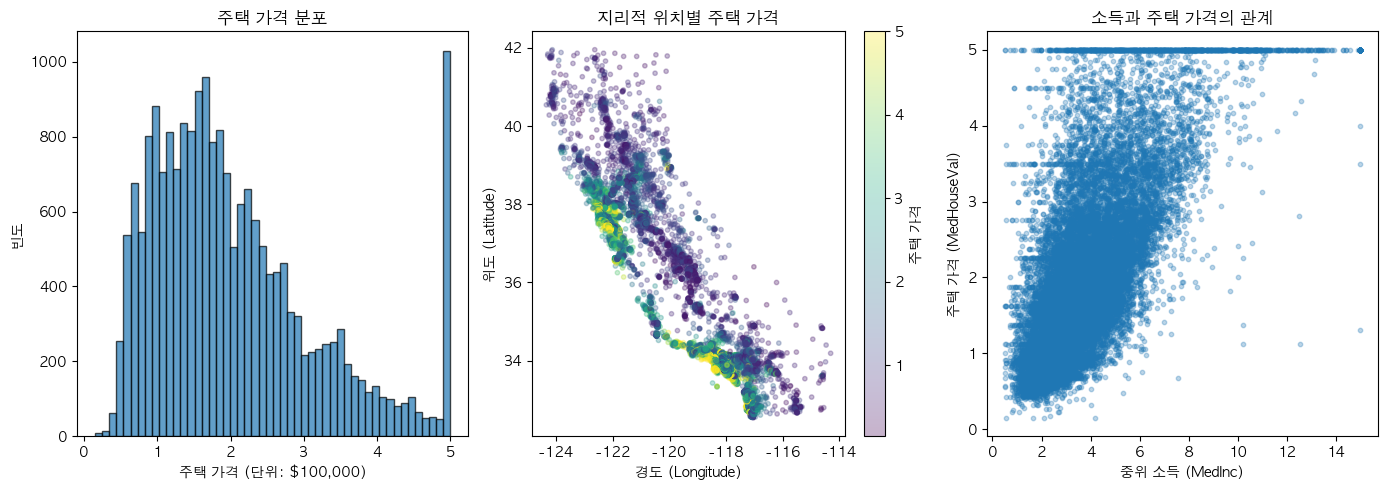

In [101]:
# 데이터 탐색 : 분포 확인
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(california_df['MedHouseVal'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('주택 가격 (단위: $100,000)')
plt.ylabel('빈도')
plt.title('주택 가격 분포')

plt.subplot(1, 3, 2)
plt.scatter(california_df['Longitude'], california_df['Latitude'], 
            c=california_df['MedHouseVal'], cmap='viridis', alpha=0.3, s=10)
plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.title('지리적 위치별 주택 가격')
plt.colorbar(label='주택 가격')

plt.subplot(1, 3, 3)
plt.scatter(california_df['MedInc'], california_df['MedHouseVal'], alpha=0.3, s=10)
plt.xlabel('중위 소득 (MedInc)')
plt.ylabel('주택 가격 (MedHouseVal)')
plt.title('소득과 주택 가격의 관계')

plt.tight_layout()
plt.show()

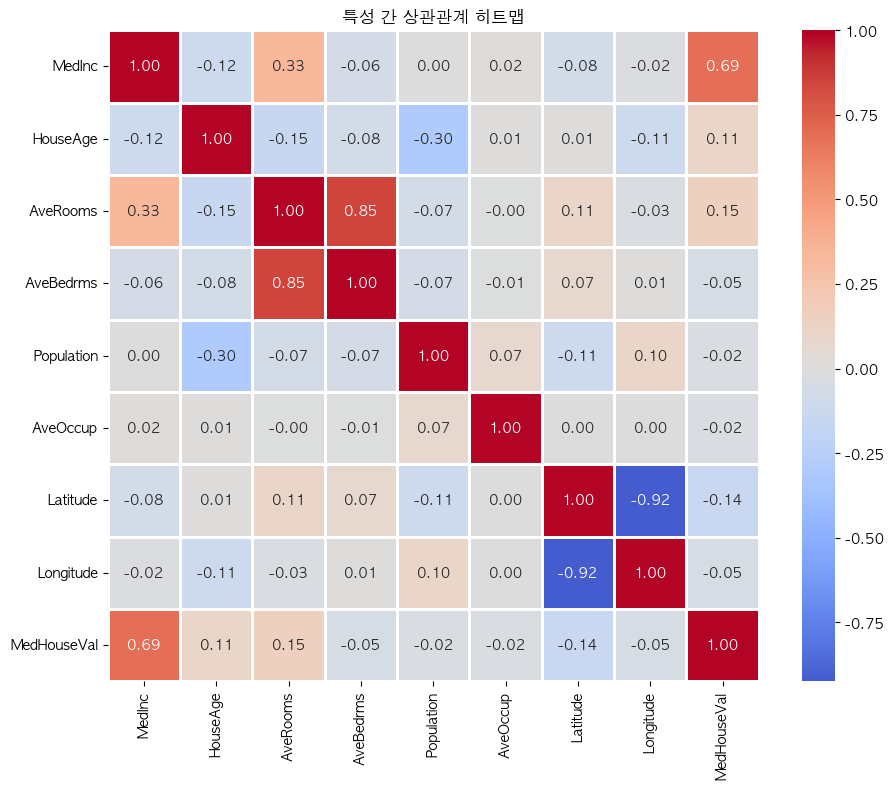

In [102]:
# 데이터 탐색 : 특성 간 상관관계 확인
plt.figure(figsize=(10, 8))
correlation_matrix = california_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('특성 간 상관관계 히트맵')
plt.tight_layout()
plt.show()

In [103]:
# 데이터 전처리 : X, y 분리
X_ca = california_df.drop('MedHouseVal', axis=1)
y_ca = california_df['MedHouseVal']

print(f"X shape: {X_ca.shape}")
print(f"y shape: {y_ca.shape}")
print(f"\n특성 목록: {X_ca.columns.tolist()}")

# 학습/테스트 데이터 분할 (80:20)
X_ca_train, X_ca_test, y_ca_train, y_ca_test = train_test_split(
    X_ca, y_ca, test_size=0.2, random_state=42
)

print(f"\n학습 데이터: {X_ca_train.shape}")
print(f"테스트 데이터: {X_ca_test.shape}")

X shape: (20640, 8)
y shape: (20640,)

특성 목록: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

학습 데이터: (16512, 8)
테스트 데이터: (4128, 8)


In [104]:
# 데이터 표준화
scaler_ca = StandardScaler()
X_ca_train_scaled = scaler_ca.fit_transform(X_ca_train)
X_ca_test_scaled = scaler_ca.transform(X_ca_test)

In [110]:
# 모델1 : 은닉층 1개
model_ca_simple = MLPRegressor(
    hidden_layer_sizes=(15,),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    verbose=True
)

print("캘리포니아 데이터 - 단순 모델 학습 시작...")
model_ca_simple.fit(X_ca_train_scaled, y_ca_train)
print("\n학습 완료!")

캘리포니아 데이터 - 단순 모델 학습 시작...
Iteration 1, loss = 2.36862447
Validation score: -1.659826
Iteration 2, loss = 1.41488029
Validation score: -0.562964
Iteration 3, loss = 0.84399698
Validation score: 0.069977
Iteration 4, loss = 0.54799052
Validation score: 0.344208
Iteration 5, loss = 0.43267707
Validation score: 0.441090
Iteration 6, loss = 0.38790849
Validation score: 0.486280
Iteration 7, loss = 0.36110620
Validation score: 0.518337
Iteration 8, loss = 0.34042770
Validation score: 0.544443
Iteration 9, loss = 0.32288089
Validation score: 0.566982
Iteration 10, loss = 0.30786363
Validation score: 0.587092
Iteration 11, loss = 0.29517275
Validation score: 0.601916
Iteration 12, loss = 0.28405976
Validation score: 0.615836
Iteration 13, loss = 0.27461452
Validation score: 0.627959
Iteration 14, loss = 0.26616368
Validation score: 0.637480
Iteration 15, loss = 0.25891767
Validation score: 0.646383
Iteration 16, loss = 0.25286430
Validation score: 0.653004
Iteration 17, loss = 0.24749896
Vali

In [111]:
# 모델2 : 은닉층 3개
model_ca_deep = MLPRegressor(
    hidden_layer_sizes=(15, 50, 25),  # 3개의 은닉층
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    verbose=True
)

print("캘리포니아 데이터 - 깊은 모델 학습 시작...")
model_ca_deep.fit(X_ca_train_scaled, y_ca_train)
print("\n학습 완료!")

캘리포니아 데이터 - 깊은 모델 학습 시작...
Iteration 1, loss = 1.01693924
Validation score: 0.205041
Iteration 2, loss = 0.40934627
Validation score: 0.540622
Iteration 3, loss = 0.29086227
Validation score: 0.620459
Iteration 4, loss = 0.25142070
Validation score: 0.658736
Iteration 5, loss = 0.23159616
Validation score: 0.681554
Iteration 6, loss = 0.22012458
Iteration 3, loss = 0.29086227
Validation score: 0.620459
Iteration 4, loss = 0.25142070
Validation score: 0.658736
Iteration 5, loss = 0.23159616
Validation score: 0.681554
Iteration 6, loss = 0.22012458
Validation score: 0.693765
Iteration 7, loss = 0.21163030
Validation score: 0.700212
Iteration 8, loss = 0.20642709
Validation score: 0.707008
Iteration 9, loss = 0.19978551
Validation score: 0.719198
Iteration 10, loss = 0.19744264
Validation score: 0.722689
Iteration 11, loss = 0.19058612
Validation score: 0.728817
Iteration 12, loss = 0.18700632
Validation score: 0.732108
Iteration 13, loss = 0.18517643
Validation score: 0.693765
Iteration 

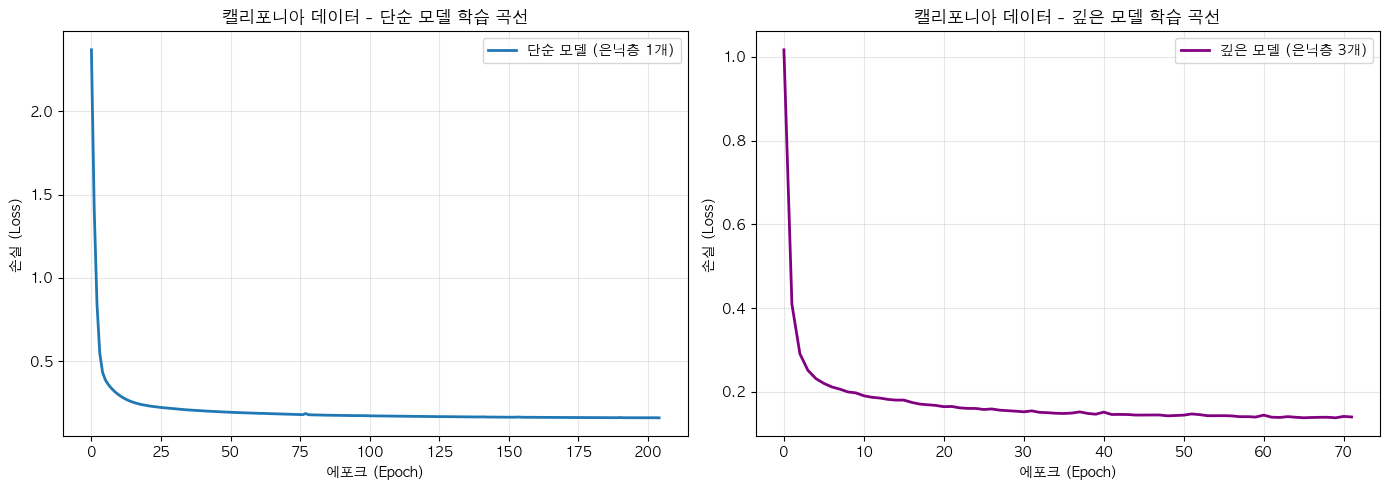

단순 모델 최종 반복 횟수: 205
깊은 모델 최종 반복 횟수: 72


In [112]:
# 학습곡선 시각화
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(model_ca_simple.loss_curve_, label='단순 모델 (은닉층 1개)', linewidth=2)
plt.xlabel('에포크 (Epoch)')
plt.ylabel('손실 (Loss)')
plt.title('캘리포니아 데이터 - 단순 모델 학습 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(model_ca_deep.loss_curve_, label='깊은 모델 (은닉층 3개)', color='purple', linewidth=2)
plt.xlabel('에포크 (Epoch)')
plt.ylabel('손실 (Loss)')
plt.title('캘리포니아 데이터 - 깊은 모델 학습 곡선')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"단순 모델 최종 반복 횟수: {model_ca_simple.n_iter_}")
print(f"깊은 모델 최종 반복 횟수: {model_ca_deep.n_iter_}")

In [113]:
# 예측
y_ca_train_pred_simple = model_ca_simple.predict(X_ca_train_scaled)
y_ca_test_pred_simple = model_ca_simple.predict(X_ca_test_scaled)

y_ca_train_pred_deep = model_ca_deep.predict(X_ca_train_scaled)
y_ca_test_pred_deep = model_ca_deep.predict(X_ca_test_scaled)

# 평가
simple_train_scores = evaluate_model(y_ca_train, y_ca_train_pred_simple, "학습 데이터", "단순 모델")
simple_test_scores = evaluate_model(y_ca_test, y_ca_test_pred_simple, "테스트 데이터", "단순 모델")

deep_train_scores = evaluate_model(y_ca_train, y_ca_train_pred_deep, "학습 데이터", "깊은 모델")
deep_test_scores = evaluate_model(y_ca_test, y_ca_test_pred_deep, "테스트 데이터", "깊은 모델")


단순 모델 - 학습 데이터
RMSE (평균 제곱근 오차): 0.56
MAE (평균 절대 오차): 0.39
R² (결정계수): 0.7638

단순 모델 - 테스트 데이터
RMSE (평균 제곱근 오차): 0.58
MAE (평균 절대 오차): 0.40
R² (결정계수): 0.7448

깊은 모델 - 학습 데이터
RMSE (평균 제곱근 오차): 0.53
MAE (평균 절대 오차): 0.36
R² (결정계수): 0.7920

깊은 모델 - 테스트 데이터
RMSE (평균 제곱근 오차): 0.55
MAE (평균 절대 오차): 0.37
R² (결정계수): 0.7721


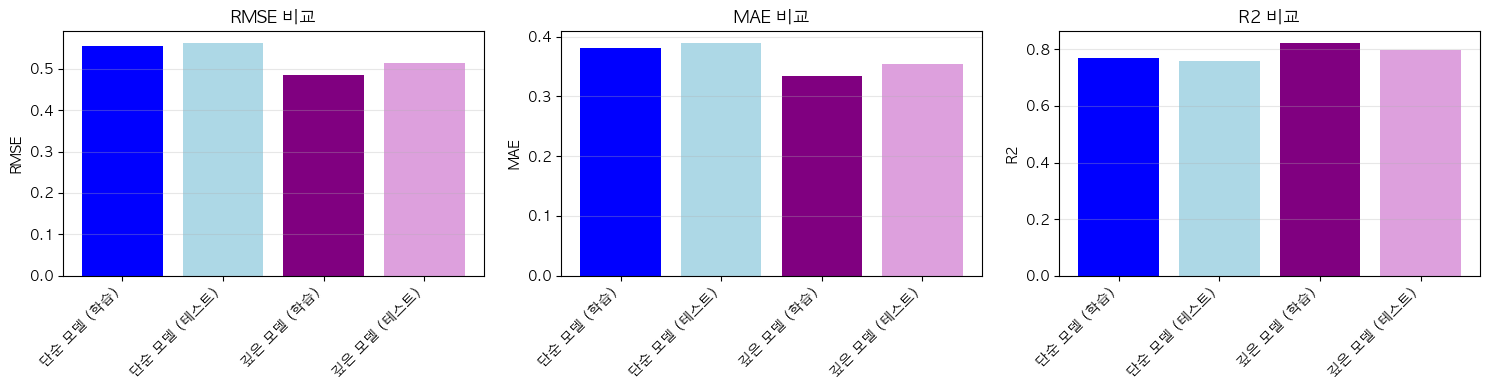

In [114]:
# 성능 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['RMSE', 'MAE', 'R2']
for i, metric in enumerate(metrics):
    values = ca_metrics_df.loc[metric]
    axes[i].bar(range(len(values)), values, color=['blue', 'lightblue', 'purple', 'plum'])
    axes[i].set_xticks(range(len(values)))
    axes[i].set_xticklabels(values.index, rotation=45, ha='right')
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'{metric} 비교')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

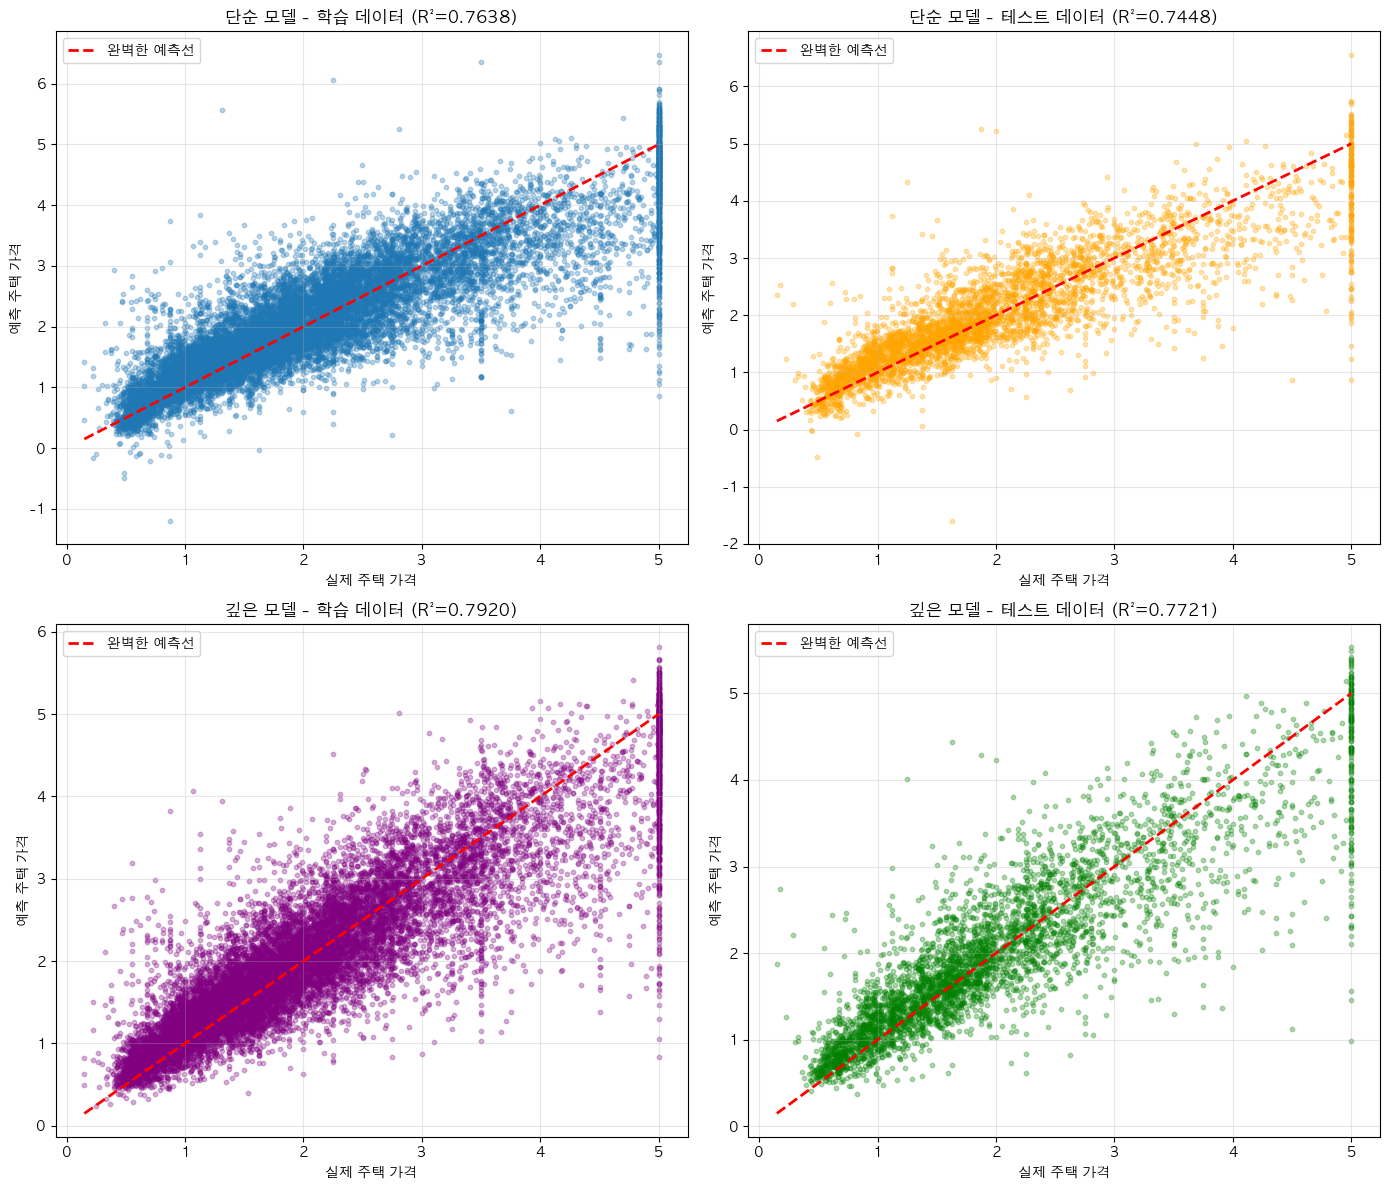

In [115]:
# 실제값 vs 예측값 비교
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 단순 모델 - 학습 데이터
axes[0, 0].scatter(y_ca_train, y_ca_train_pred_simple, alpha=0.3, s=10)
axes[0, 0].plot([y_ca_train.min(), y_ca_train.max()], 
                [y_ca_train.min(), y_ca_train.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[0, 0].set_xlabel('실제 주택 가격')
axes[0, 0].set_ylabel('예측 주택 가격')
axes[0, 0].set_title(f'단순 모델 - 학습 데이터 (R²={simple_train_scores["R2"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 단순 모델 - 테스트 데이터
axes[0, 1].scatter(y_ca_test, y_ca_test_pred_simple, alpha=0.3, s=10, color='orange')
axes[0, 1].plot([y_ca_test.min(), y_ca_test.max()], 
                [y_ca_test.min(), y_ca_test.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[0, 1].set_xlabel('실제 주택 가격')
axes[0, 1].set_ylabel('예측 주택 가격')
axes[0, 1].set_title(f'단순 모델 - 테스트 데이터 (R²={simple_test_scores["R2"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 깊은 모델 - 학습 데이터
axes[1, 0].scatter(y_ca_train, y_ca_train_pred_deep, alpha=0.3, s=10, color='purple')
axes[1, 0].plot([y_ca_train.min(), y_ca_train.max()], 
                [y_ca_train.min(), y_ca_train.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[1, 0].set_xlabel('실제 주택 가격')
axes[1, 0].set_ylabel('예측 주택 가격')
axes[1, 0].set_title(f'깊은 모델 - 학습 데이터 (R²={deep_train_scores["R2"]:.4f})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 깊은 모델 - 테스트 데이터
axes[1, 1].scatter(y_ca_test, y_ca_test_pred_deep, alpha=0.3, s=10, color='green')
axes[1, 1].plot([y_ca_test.min(), y_ca_test.max()], 
                [y_ca_test.min(), y_ca_test.max()], 
                'r--', lw=2, label='완벽한 예측선')
axes[1, 1].set_xlabel('실제 주택 가격')
axes[1, 1].set_ylabel('예측 주택 가격')
axes[1, 1].set_title(f'깊은 모델 - 테스트 데이터 (R²={deep_test_scores["R2"]:.4f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

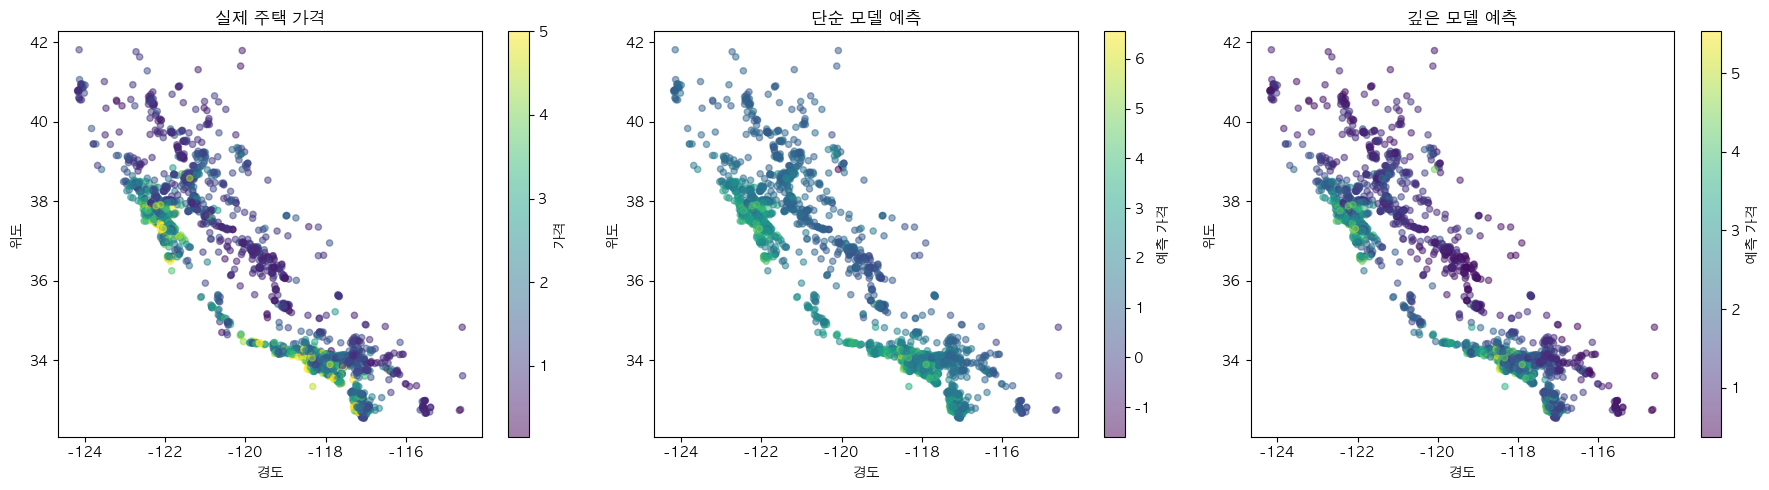

In [116]:
# 지리적 위치에 따른 예측 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 실제값
scatter1 = axes[0].scatter(X_ca_test['Longitude'], X_ca_test['Latitude'], 
                           c=y_ca_test, cmap='viridis', alpha=0.5, s=20)
axes[0].set_xlabel('경도')
axes[0].set_ylabel('위도')
axes[0].set_title('실제 주택 가격')
plt.colorbar(scatter1, ax=axes[0], label='가격')

# 단순 모델 예측
scatter2 = axes[1].scatter(X_ca_test['Longitude'], X_ca_test['Latitude'], 
                           c=y_ca_test_pred_simple, cmap='viridis', alpha=0.5, s=20)
axes[1].set_xlabel('경도')
axes[1].set_ylabel('위도')
axes[1].set_title('단순 모델 예측')
plt.colorbar(scatter2, ax=axes[1], label='예측 가격')

# 깊은 모델 예측
scatter3 = axes[2].scatter(X_ca_test['Longitude'], X_ca_test['Latitude'], 
                           c=y_ca_test_pred_deep, cmap='viridis', alpha=0.5, s=20)
axes[2].set_xlabel('경도')
axes[2].set_ylabel('위도')
axes[2].set_title('깊은 모델 예측')
plt.colorbar(scatter3, ax=axes[2], label='예측 가격')

plt.tight_layout()
plt.show()

데이터의 수가 많은 데이터셋에서는 신경망의 장점이 더욱 부각됩니다. 특히 은닉층을 늘린 "깊은" 모형의 경우 예측 성능이 개선되는 것을 가시적으로 확인할 수 있습니다.  